## Proyecto de Evaluación de tumores Malignos - Benignos en Cáncer de Mama
### *Wisconsin University Dataset*
### *Seminarios Data Science para Radiología*
* **Dr. Héctor Henríquez Leighton**
* **Clínica Santa María - Universidad de los Andes**

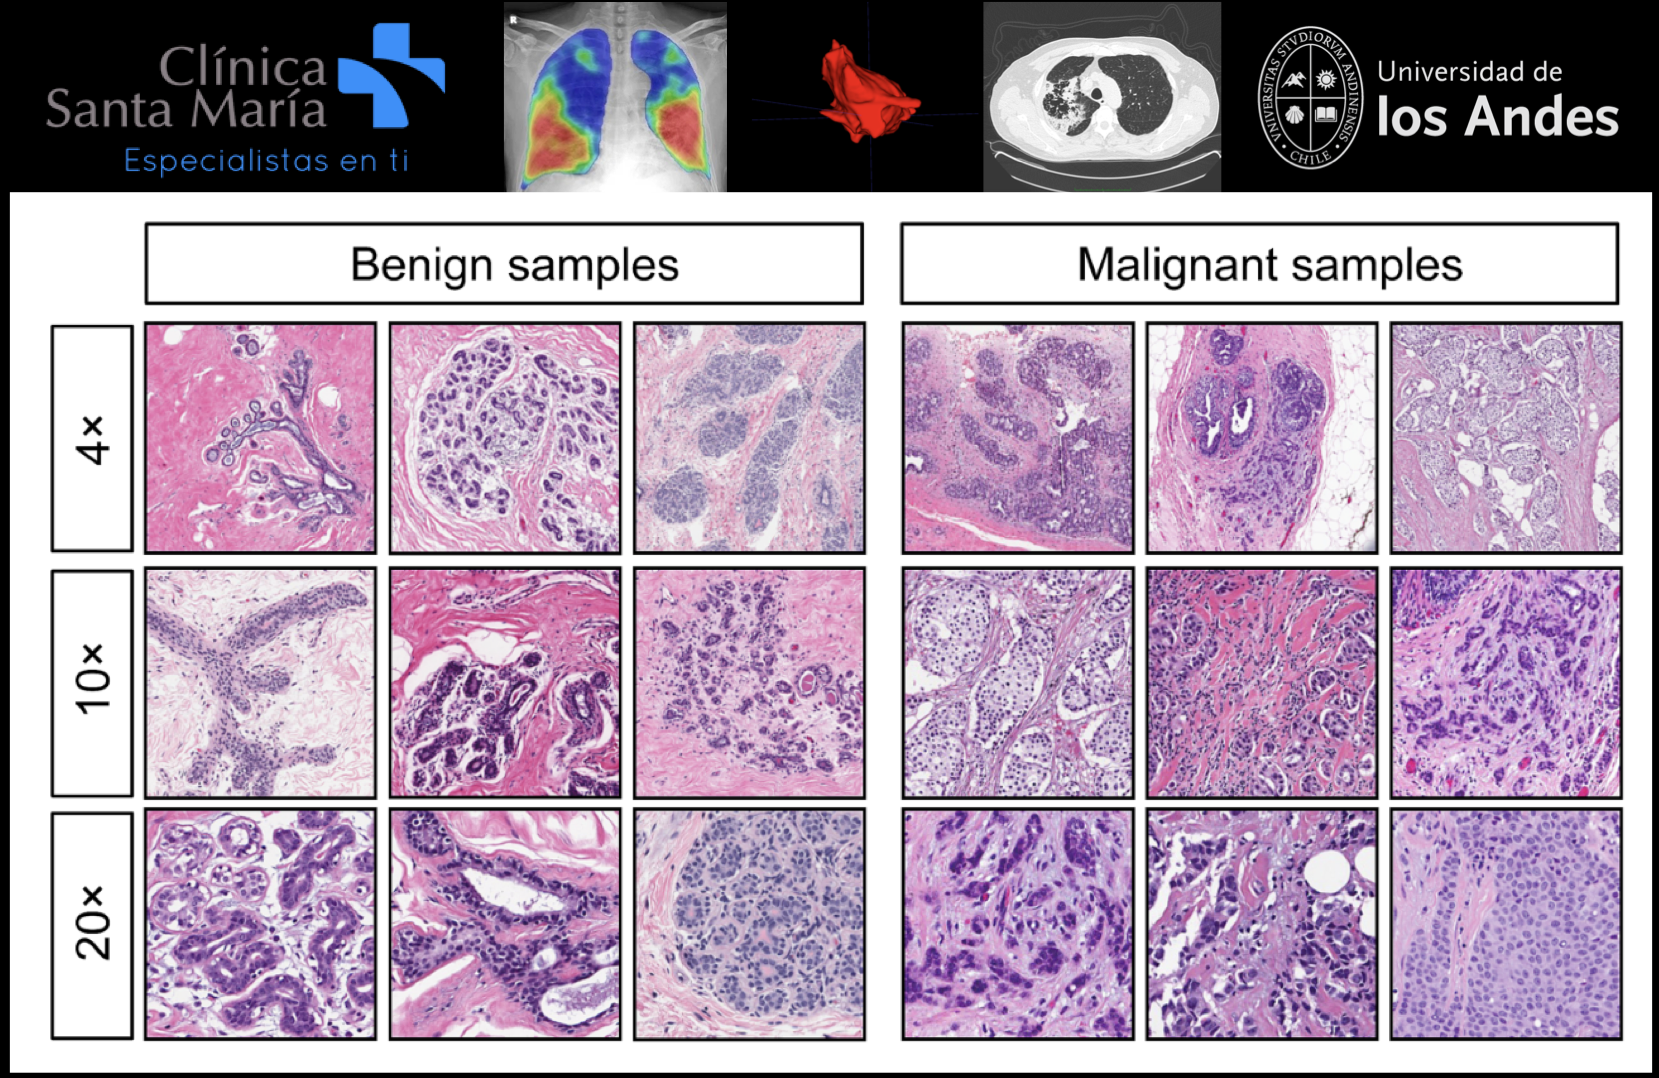

Este set de datos se encuentra disponible en los repositorios de la Universidad
de Wisconsin:

https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29


Creadores:

1. Dr. William H. Wolberg, General Surgery Dept.
University of Wisconsin, Clinical Sciences Center
Madison, WI 53792
wolberg '@' eagle.surgery.wisc.edu

2. W. Nick Street, Computer Sciences Dept.
University of Wisconsin, 1210 West Dayton St., Madison, WI 53706
street '@' cs.wisc.edu 608-262-6619

3. Olvi L. Mangasarian, Computer Sciences Dept.
University of Wisconsin, 1210 West Dayton St., Madison, WI 53706
olvi '@' cs.wisc.edu


Información del set de datos:

Las características que se describen a continuación fueron calculadas a partir de imágenes digitalizadas de muestras de aspiración con aguja fina de masas mamarias. Describen las características morfológicas del núcleo celular presente en la imagen.

### **El objetivo de este notebook es realizar el análisis exploratorio de este set de características radiómicas y modelar las variables para predecir la malignidad o benignidad del tumor.**

* This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

In [116]:
## Cargar Librerias Relevantes

## Manejo de datos generales
import pandas as pd
import numpy as np
import joblib
from collections import Counter

# Visualización
from plotnine import*
import matplotlib.pyplot as plt

# Modelamiento de datos
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.model_selection import train_test_split, KFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE 
from sklearn import metrics as mt
from sklearn import datasets
import statsmodels.api as sm

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro


## Medición de timpo y flujo de trabajo
import time
from tqdm import trange

## Sistema
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
from IPython.display import clear_output


In [76]:
## Se carga set de datos como array
raw_data = datasets.load_breast_cancer()

##Se convierte a data tabular para visualización y manejo de variables
data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)

##Se agrega variable target (maligno-benigno)
data.insert(loc=0, column='target', value= raw_data.target)

print("Etiquetas de target:\n","Clase 0: {}\n Clase 1: {}".format(raw_data.target_names[0], raw_data.target_names[1]))

## Distribución de variable Target
print("Recuento:")
print(data['target'].value_counts())
print("\nDimensiones set de datos:\n Filas:{}\n Columnas:{}".format(data.shape[0], data.shape[1]))
pd.set_option('display.max_columns', None)
data.head(10)


Etiquetas de target:
 Clase 0: malignant
 Clase 1: benign
Recuento:
1    357
0    212
Name: target, dtype: int64

Dimensiones set de datos:
 Filas:569
 Columnas:31


,target,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,0,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,0,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,0,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,0,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,0,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [77]:
## Estadísticos generales
data.describe()

,target,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.627417,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,1.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [78]:
## Exploración de Variables:
print("Cantidad de variables:", len(data.columns))
print(data.columns)

Cantidad de variables: 31
Index(['target', 'mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


### ¿Cuáles variables son relevantes para la predicción de tumores benignos?

* Se realiza test media para cada una de las variables independientes.

In [142]:
## Test de medias de entre las diferentes variables

indice_significativo = []
var_sig = []
benign_values = []
malignant_values = []
p_value = []

for i in range(1,len(data[data['target'] == 1].columns)):
    var = data[data['target'] == 1].columns[i]
    x = data[data['target'] == 0][var].dropna()
    y = data[data['target'] == 1][var].dropna()

    shapiro_test = stats.shapiro(x)
    if (shapiro_test[1] < 0.05): ## entonces distribucion no es normal
        U1, p = mannwhitneyu(x, y)
       
    else:
        st, p = stats.ttest_ind(x, y, equal_var=False)
        
    promedio_x = str(round(x.mean(),4)) + ' (+/-' + str(round(x.std(),4)) +')'
    promedio_y = str(round(y.mean(),4)) + ' (+/-' + str(round(y.std(),4)) +')'
    benign_values.append(promedio_x)
    malignant_values.append(promedio_y)
    
    if (p < 0.05):
        valor_p = (round(p,5))
        if(p < 0.001):
            valor_p = str('<0.001')
    else:
        valor_p = (round(p,5))
    p_value.append(valor_p)    
        
    if (p < 0.05):
        indice_significativo.append(i)
        var_sig.append(var)
    
df = pd.DataFrame(columns=['Variable', 'Benigno', 'Maligno', 'valor p'])
df['Variable'] = data[data['target'] == 1].columns[1:]
df['Benigno'] = benign_values
df['Maligno'] = malignant_values
df['valor p'] = p_value

df.head(50)

,Variable,Benigno,Maligno,valor p
0,mean radius,17.4628 (+/-3.204),12.1465 (+/-1.7805),<0.001
1,mean texture,21.6049 (+/-3.7795),17.9148 (+/-3.9951),<0.001
2,mean perimeter,115.3654 (+/-21.8547),78.0754 (+/-11.8074),<0.001
3,mean area,978.3764 (+/-367.938),462.7902 (+/-134.2871),<0.001
4,mean smoothness,0.1029 (+/-0.0126),0.0925 (+/-0.0134),<0.001
5,mean compactness,0.1452 (+/-0.054),0.0801 (+/-0.0337),<0.001
6,mean concavity,0.1608 (+/-0.075),0.0461 (+/-0.0434),<0.001
7,mean concave points,0.088 (+/-0.0344),0.0257 (+/-0.0159),<0.001
8,mean symmetry,0.1929 (+/-0.0276),0.1742 (+/-0.0248),<0.001
9,mean fractal dimension,0.0627 (+/-0.0076),0.0629 (+/-0.0067),0.53719


### El análisis univariado muestra una gran cantidad de variables con diferencia significativa:

In [80]:
print("Cantidad de variables significativas - p_value < 0.05:", len(var_sig))

Cantidad de variables significativas - p_value < 0.05: 27


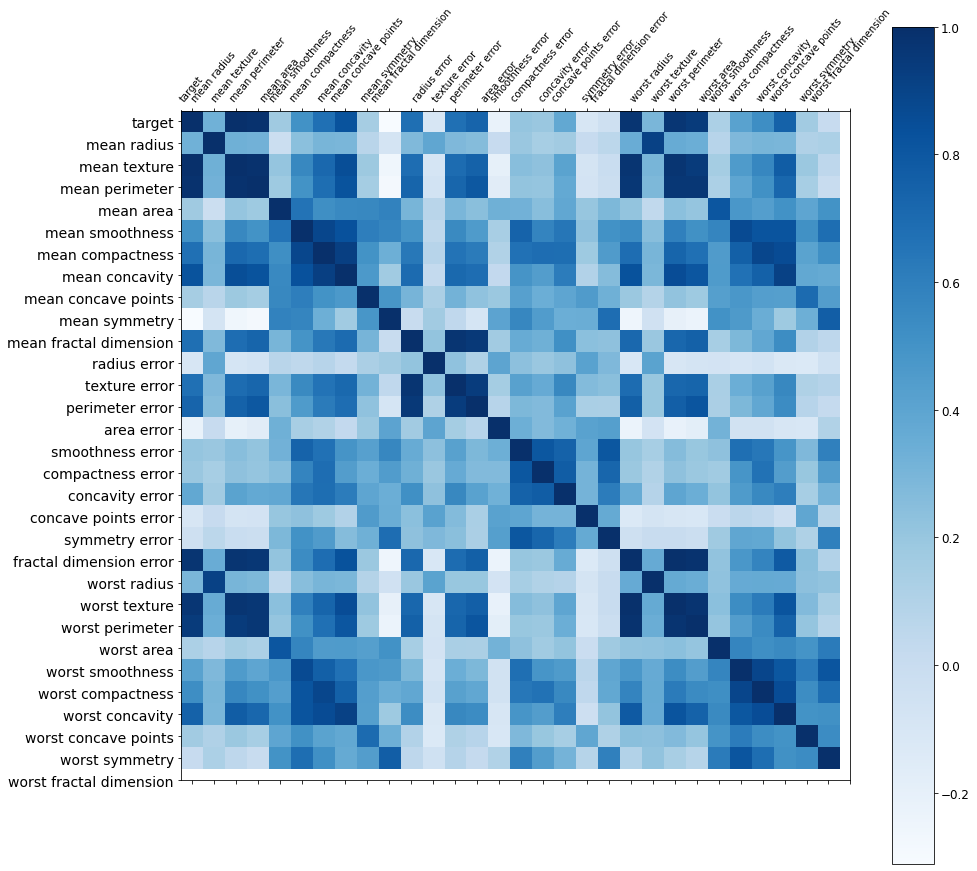

In [81]:
## Matriz de correlaciones

## En la matriz de correlaciones se pueden ver algunas variables que estan fuertemente correlacionadas entre ellas.

f = plt.figure(figsize=(15, 15))
plt.matshow(data.iloc[:,1:].corr(), fignum=f.number, cmap='Blues')
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=10, rotation=50)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)


## Preparación de modelos univariados de Regresión logistica

* Se realizan modelos univariados de Regresión Logística para tener una idea del proder predictivo de cada variable.

In [82]:
## Separamos los datos en variables X, y

X = data.iloc[:,1:]
y = data.iloc[:,0]
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [83]:

### modelo univariados de regresión logistica con calculo de AUC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51)

## Oversampling

print(Counter(y_test))

auc = []
f_score = []

for i in range(X_train.shape[1]):
    logreg = LogisticRegression()
    X_train_temp = np.array(X_train.iloc[:,i])
    X_train_temp = X_train_temp.reshape(-1, 1)
    X_test_temp = np.array(X_test.iloc[:,i])
    X_test_temp = X_test_temp.reshape(-1, 1)
    logreg.fit(X_train_temp, y_train)
    y_pred = logreg.predict(X_test_temp)
    fpr, tpr, thresholds = mt.roc_curve(y_pred,y_test)
    auc_test = mt.auc(fpr,tpr)
    f_score_test = mt.f1_score(y_test,y_pred, pos_label=0)
    auc.append(auc_test)
    f_score.append(f_score_test)


df_auc = pd.DataFrame(columns=['variable', 'AUC', 'F-Score'])

df_auc['variable'] = X_train.columns
df_auc['AUC'] = auc
df_auc['F-Score'] = f_score

df['AUC'] = auc
df['F-Score'] = f_score
df_auc.sort_values(by=['F-Score'], ascending=False).head(15) ## se muestran las primeras 15 filas de los resultados


Counter({1: 110, 0: 61})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value sh

,variable,AUC,F-Score
22,worst perimeter,0.903509,0.864407
20,worst radius,0.902451,0.839286
23,worst area,0.902451,0.839286
0,mean radius,0.813323,0.741379
2,mean perimeter,0.813323,0.741379
3,mean area,0.813323,0.741379
13,area error,0.846032,0.735849
26,worst concavity,0.858713,0.693878
25,worst compactness,0.812030,0.646465
12,perimeter error,0.809682,0.610526


### Visualización de Variables

Variable elegida: area error


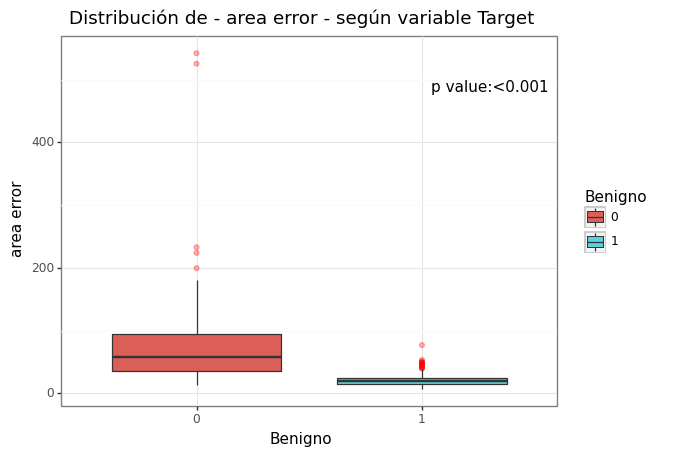

<ggplot: (8738359538277)>

In [105]:
## Visualizamos algunas de las variables con mayor poder predictivo

## primeras 27 variables:
max_variable = 27

## Se selecciona una variable aleatoria
variable = df_auc.sort_values(by=['F-Score'], ascending=False)['variable'].iloc[np.random.randint(0,max_variable)]
print("Variable elegida:", variable)


(
    
  ggplot(data) + 
  aes(x = 'factor(target)', y='{}'.format(variable), fill='factor(target)') + 
  geom_boxplot(outlier_color='red', outlier_alpha= 0.3) +
  theme_bw() + 
 labs(title='Distribución de - {} - según variable Target'.format(variable), x='Benigno', fill='Benigno')+
 annotate('text', x=2.3, y=data[variable].max() * 0.9, colour='black', label= 'p value:{}'.format(df[df['Variable'] == variable]['valor p'].iloc[0]))
)

### Selección de variables

## Se realiza selección de variable con método Backward Selection.

https://quantifyinghealth.com/stepwise-selection/

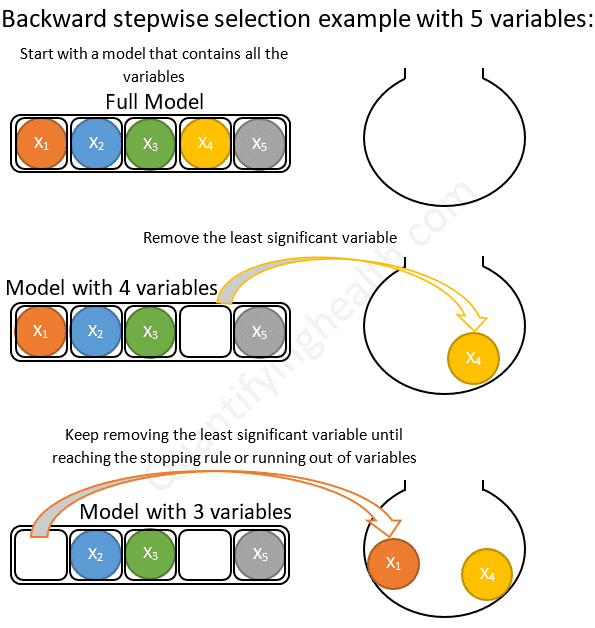

In [66]:
### Búsqueda de Hiperparámetros de RF: gridSearch

start = time.time()

parameters = {'n_estimators': list(range(50,100,1)), 'criterion':['gini', 'entropy'], 'max_depth': list(range(2,5)),
              'min_samples_split': list(range(1,4)), 'min_samples_leaf': list(range(1,4)), 'max_leaf_nodes': list(range(1,4)),
              'class_weight' :['balanced']
             }

RF = RandomForestClassifier()

grid = GridSearchCV(RF, parameters, refit = True, verbose=2, cv=5, n_jobs=-1)

grid.fit(X,y)

end= time.time()
print("tiempo total de iteración:", (end-start)/60, 'minutos')

Fitting 5 folds for each of 8100 candidates, totalling 40500 fits
tiempo total de iteración: 45.85520385106405 minutos


In [67]:
## Mejores parámetros
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 2,
 'max_leaf_nodes': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 71}

In [90]:


start = time.time()

clf = RandomForestClassifier(n_estimators=71, max_depth= 2, class_weight = 'balanced', criterion = 'gini',max_leaf_nodes = 3,
                                 min_samples_leaf = 1, min_samples_split = 3)

numero_features = 2

#feature selection
feature_selector = sfs(clf,
           k_features= numero_features,
           forward=False,
           floating=False,
           verbose=0,
           scoring='f1',
           cv=5)

# Perform SFFS
feature_selector = feature_selector.fit(X.values, y)
print("Tiempo total de iteración:{} minutos".format((time.time() - start)/60))


Tiempo total de iteración:5.567614471912384 minutos


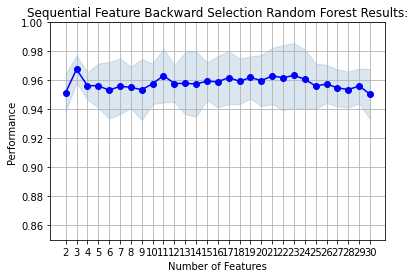

In [94]:
fig1 = plot_sfs(feature_selector.get_metric_dict(), kind='std_dev')

plt.ylim(0.85,1.0)
plt.title('Sequential Feature Backward Selection Random Forest Results:')
plt.grid()
plt.show()

In [100]:
## Se muestran los 5 mejores resultados con el número de variables

df_feature_selector = pd.DataFrame.from_dict(feature_selector.get_metric_dict()).T

df_feature_selector.sort_values(by='avg_score', axis=0, ascending=False).head(5)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(21, 23, 27)","[0.9583333333333334, 0.9583333333333334, 0.978...",0.967641,"(21, 23, 27)",0.012185,0.00948,0.00474
23,"(1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16,...","[0.921985815602837, 0.9655172413793103, 0.9859...",0.963396,"(1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16,...",0.028578,0.022235,0.011117
11,"(7, 11, 12, 13, 14, 16, 19, 20, 21, 23, 27)","[0.9285714285714286, 0.9655172413793103, 0.979...",0.96329,"(7, 11, 12, 13, 14, 16, 19, 20, 21, 23, 27)",0.023804,0.01852,0.00926
21,"(1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17,...","[0.927536231884058, 0.9655172413793103, 0.9645...",0.963026,"(1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17,...",0.024867,0.019347,0.009674
19,"(1, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 18, 19...","[0.9370629370629372, 0.9655172413793103, 0.978...",0.96201,"(1, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 18, 19...",0.018611,0.01448,0.00724


In [101]:
## Se puede ver que el rendimiento mas alto se obtiene con 3 variables

selected_features = X.iloc[:,[21, 23, 27]].columns

X2 = X.loc[:,selected_features]
X2.head(2)

,worst texture,worst area,worst concave points
0,17.33,2019.0,0.2654
1,23.41,1956.0,0.1860


## Se ajustan 3 diferentes modelos

In [106]:
def evaluacionModelo(y_true, y_pred, nombre_modelo, particion):
    """
    Función que calcula principales métricas de clasificación.
    Input: Recibe el y_true del set de datos que corresponda y las predicciones binarizadas.
    Se agrega el nombre del modelo para rótulo y el nombre de la partición (Train - Test), para
    ser agregado al nombre de la variable.
    Output: Devuelve DataFrame con los resultados de cada K-Fold.
    """
 
    AccTrain= mt.accuracy_score(y_true,y_pred)
    F1Train = mt.f1_score(y_true,y_pred, pos_label=1, average='binary',zero_division = 0)
    Precision = mt.precision_score(y_true,y_pred,pos_label=1,average="binary",zero_division = 0)
    Recall = mt.recall_score(y_true,y_pred,labels=[1],average=None,zero_division = 0)
    fpr, tpr, thresholds = mt.roc_curve(y_true,y_pred)
    Auc = mt.auc(fpr,tpr)
    

    nombres_metricas = ['AccMean_{}'.format(particion), 'F1ScoreMean_{}'.format(particion),
                        'PrecisionMean_{}'.format(particion), 'RecallMean_{}'.format(particion),
                    'AUCMean_{}'.format(particion)]
    
    df_resultados = pd.DataFrame(columns=nombres_metricas, index=range(1))
    
    metricas = [AccTrain, F1Train, Precision, Recall, Auc]

    promedios = []

    for metrica in metricas:
        promedio = metrica.mean()
        promedios.append(promedio)

    promedios = np.array(promedios)
    df_resultados.iloc[0] = promedios
    
    df_resultados.insert(loc=0,
                        column='Modelo',
                        value = nombre_modelo)
    clear_output(wait=False)

    
    
    return(df_resultados)

## Regresión Logística

### Validación Cruzada de 5 grupos

In [114]:

numFolds=5

umbral = 0.5

df_resultadosRL = pd.DataFrame()
y_trues_RL = []
y_preds_RL = []
    
kf = KFold(n_splits=numFolds,shuffle=True)

temp=kf.split(X2)


for train_index, test_index in temp:
  X_train = X2.iloc[train_index,:]
  y_train = y.iloc[train_index]
  X_test = X2.iloc[test_index,:]
  y_test = y.iloc[test_index]
        
  logit_model = sm.Logit(y_train, X_train).fit()
  pred_train = logit_model.predict(X_train)
  pred_train_bin = np.where(pred_train > umbral,1,0)

  pred_test = logit_model.predict(X_test)
  pred_test = logit_model.predict(X_test)
  y_preds_RL.append(list(pred_test))
  y_trues_RL.append(list(y_test))
            
  pred_test_bin = np.where(pred_test> umbral,1,0)

  resultadosTrain = evaluacionModelo(y_train, pred_train_bin, 'RLog', 'Train')
  resultadosTest = evaluacionModelo(y_test, pred_test_bin, 'RLog', 'Test')
  resultadosTrain = resultadosTrain.merge(resultadosTest, on='Modelo')
  df_resultadosRL = df_resultadosRL.append(resultadosTrain)
        


print(df_resultadosRL.mean())

AccMean_Train          0.845341
F1ScoreMean_Train      0.876166
PrecisionMean_Train    0.878769
RecallMean_Train       0.873649
AUCMean_Train          0.835228
AccMean_Test           0.841810
F1ScoreMean_Test       0.872656
PrecisionMean_Test     0.877358
RecallMean_Test        0.868785
AUCMean_Test           0.832183
dtype: float64


## KNN

In [117]:
## GridSearch KNN
start = time.time()

parameters = {'n_neighbors': list(range(1,15,1)), 'weights':['uniform', 'distance'], 'p': [1,2],
              'algorithm': ['auto','ball_tree', 'kd_tree', 'brute'], 'leaf_size': list(range(10,50)), 'metric': ['minkowski']
             }

                     
KNN = KNeighborsClassifier()

grid = GridSearchCV(KNN, parameters, refit = True, verbose=1, cv=5, scoring='f1', n_jobs=-1)


grid.fit(X2,y)

end= time.time()
print("tiempo total de iteración:", (end-start)/60, 'minutos')


Fitting 5 folds for each of 8960 candidates, totalling 44800 fits
tiempo total de iteración: 8.038563124338786 minutos


In [118]:
print(grid.best_params_)

{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}


In [125]:

numFolds=5

kf = KFold(n_splits=numFolds,shuffle=True)

temp=kf.split(X2)

df_resultadosKNN = pd.DataFrame()

y_trues_knn = []

y_preds_knn = []


for train_index, test_index in temp:
  X_train = X2.iloc[train_index,:]
  y_train = y.iloc[train_index]
  X_test = X2.iloc[test_index,:]
  y_test = y.iloc[test_index]
        
  KNN = KNeighborsClassifier(n_neighbors=13, algorithm = 'auto', leaf_size=10, metric='minkowski', p=1, weights='uniform')
  KNN.fit(X_train, y_train)

  pred_train = KNN.predict(X_train)
  pred_test = KNN.predict(X_test)
  score_test = KNN.predict_proba(X_test)
        
  y_preds_knn.append(list(score_test[:,1]))
  y_trues_knn.append(list(y_test))
          
  resultadosTrain = evaluacionModelo(y_train, pred_train, 'KNN', 'Train')
  resultadosTest = evaluacionModelo(y_test, pred_test, 'KNN', 'Test')
  resultadosTrain = resultadosTrain.merge(resultadosTest, on='Modelo')
  df_resultadosKNN = df_resultadosKNN.append(resultadosTrain)
        


print(df_resultadosKNN.mean())

AccMean_Train          0.924870
F1ScoreMean_Train      0.941861
PrecisionMean_Train    0.914404
RecallMean_Train       0.971130
AUCMean_Train          0.908700
AccMean_Test           0.919159
F1ScoreMean_Test       0.936971
PrecisionMean_Test     0.907236
RecallMean_Test        0.970630
AUCMean_Test           0.905582
dtype: float64


## Decision Tree Classifier

In [130]:
from sklearn.tree import DecisionTreeClassifier



start = time.time()

parameters = {'max_depth': list(range(1,30,1)), 'criterion':['gini', 'entropy'], 'splitter': ['best', 'random'],
              'min_samples_split': list(range(2,5)), 'min_samples_leaf': list(range(2,6)), 'class_weight': ['balanced']
                                                                              }

                                         
DT = DecisionTreeClassifier()


grid = GridSearchCV(DT, parameters, refit = True, verbose=1, cv=5, n_jobs=-1, scoring='f1')

grid.fit(X2,y)

end= time.time()
print("tiempo total de iteración:", (end-start)/60, 'minutos')
print(grid.best_params_)


Fitting 5 folds for each of 1392 candidates, totalling 6960 fits
tiempo total de iteración: 0.7878532648086548 minutos
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 28, 'min_samples_leaf': 4, 'min_samples_split': 3, 'splitter': 'random'}


In [138]:
numFolds=5

kf = KFold(n_splits=numFolds,shuffle=True)

temp=kf.split(X2)


df_resultadosDT = pd.DataFrame()
y_preds_DT = []
y_trues_DT = []



for train_index, test_index in temp:
  X_train = X2.iloc[train_index,:]
  y_train = y.iloc[train_index]
  X_test = X2.iloc[test_index,:]
  y_test = y.iloc[test_index]
        
  DT = DecisionTreeClassifier(max_depth = 28, min_samples_leaf = 4, min_samples_split=3,
                                  splitter = 'random', criterion='entropy', class_weight='balanced')
  DT.fit(X_train, y_train)

  pred_train = DT.predict(X_train)
  pred_test = DT.predict(X_test)

  y_preds_DT.append(list(pred_test))
  y_trues_DT.append(list(y_test))
          
  resultadosTrain = evaluacionModelo(y_train, pred_train, 'DT', 'Train')
  resultadosTest = evaluacionModelo(y_test, pred_test, 'DT', 'Test')
  resultadosTrain = resultadosTrain.merge(resultadosTest, on='Modelo')
  df_resultadosDT = df_resultadosDT.append(resultadosTrain)
        


print(df_resultadosDT.mean())

AccMean_Train          0.940266
F1ScoreMean_Train      0.950465
PrecisionMean_Train    0.974187
RecallMean_Train       0.928803
AUCMean_Train          0.943792
AccMean_Test           0.924391
F1ScoreMean_Test       0.938199
PrecisionMean_Test     0.971314
RecallMean_Test        0.909633
AUCMean_Test           0.931540
dtype: float64


## Comparación de los 3 Modelos


In [141]:
def vectorizer(y_trues, y_preds):
    
    """
    Descripción: Función que convierte las listas de los resultados de la validación cruzada iterativa, en un vector.
    Input: Lista con listas que contienen los resultados de cada validación cruzada.
    Output: Vector 1D.
    """

    vector_pred = []
    vector_respuesta = []

    for i in range(len(y_preds)):
        for j in range(len(y_preds[i])):
            vector_pred.append(y_preds[i][j])
            
    for i in range(len(y_trues)):
        for j in range(len(y_trues[i])):
            vector_respuesta.append(y_trues[i][j])
    vector_pred = np.array(vector_pred)
    vector_respuesta = np.array(vector_respuesta)
    
    return(vector_respuesta, vector_pred)


def curva_roc(vector_respuesta, vector_prediccion, nombre_modelo):
    
    """
    Función que genera gráfico de Curva ROC.
    Input: Recibe los vectores de respuesta y predicción, además del nombre del modelo para agregarlo en el título.
    Output: Gráfico.
    """
    
    fpr, tpr, thresholds = mt.roc_curve(vector_respuesta, vector_prediccion, pos_label=1)


    df_auc = pd.DataFrame()
    df_auc['TPR'] = tpr
    df_auc['FPR'] = fpr

    grafico_auc = (
    ggplot(df_auc) +
        geom_line(aes(x='FPR', y='TPR'),color='blue') +
        annotate("segment", x = 0, xend = 1, y = 0, yend = 1,colour = "black", size=0.5, alpha=0.5)+
        theme_bw() +
        labs(title='ROC {}'.format(nombre_modelo))
    )
    return(grafico_auc)


def tablificador (dataframe_list):
    tabla = pd.DataFrame(columns = dataframe_list[0].columns)
    tabla.columns = tabla.columns.str.replace('Mean', '')
    for dataframe in dataframe_list:
        mean = dataframe.mean().to_dict()
        std = dataframe.std().to_dict()
        fila = [dataframe.iloc[0,0]] + ["{:.3f} ± {:.3f}".format(mean[k], std[k])for k in mean.keys()]
        tabla.loc[dataframe.iloc[0,0]] = fila
    return tabla

In [140]:
## Consolidación de los dataframe de resultados
listaDataFrames = [df_resultadosRL, df_resultadosKNN, df_resultadosDT]

dataTotalCombinada= tablificador(listaDataFrames)

dataTotalCombinada.head(4)

,Modelo,Acc_Train,F1Score_Train,Precision_Train,Recall_Train,AUC_Train,Acc_Test,F1Score_Test,Precision_Test,Recall_Test,AUC_Test
RLog,RLog,0.845 ± 0.009,0.876 ± 0.011,0.879 ± 0.007,0.874 ± 0.016,0.835 ± 0.008,0.842 ± 0.014,0.873 ± 0.014,0.877 ± 0.026,0.869 ± 0.024,0.832 ± 0.018
KNN,KNN,0.925 ± 0.007,0.942 ± 0.006,0.914 ± 0.009,0.971 ± 0.010,0.909 ± 0.009,0.919 ± 0.024,0.937 ± 0.021,0.907 ± 0.046,0.971 ± 0.026,0.906 ± 0.026
DT,DT,0.940 ± 0.030,0.950 ± 0.027,0.974 ± 0.004,0.929 ± 0.049,0.944 ± 0.024,0.924 ± 0.028,0.938 ± 0.022,0.971 ± 0.028,0.910 ± 0.053,0.932 ± 0.020


## Visualización del rendimiento de los modelos

In [152]:
vector_respuesta_RL, vector_prediccion_RL = vectorizer(y_trues_RL, y_preds_RL)
vector_respuesta_KNN, vector_prediccion_KNN = vectorizer(y_trues_knn, y_preds_knn)
vector_respuesta_DT, vector_prediccion_DT = vectorizer(y_trues_DT, y_preds_DT)

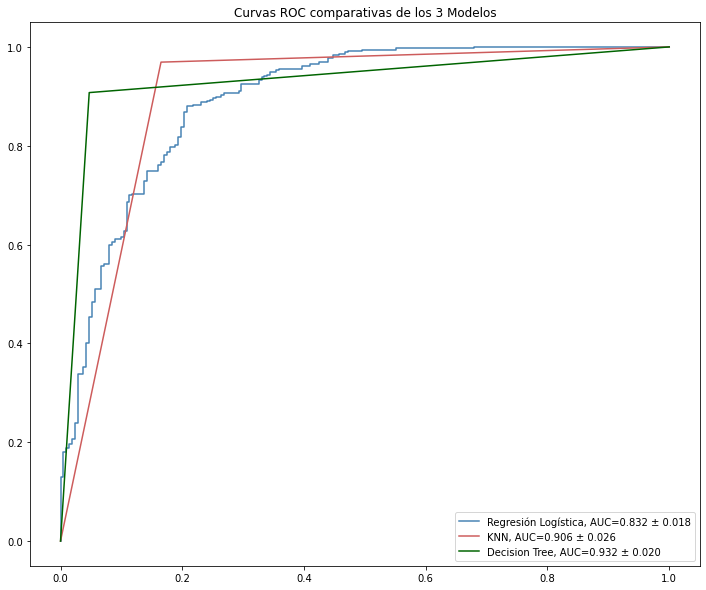

In [154]:
## Curvas ROC Combinados
plt.figure(figsize=(12,10)).clf()

fpr_rl, tpr_rl, _ = mt.roc_curve(vector_respuesta_RL, vector_prediccion_RL, pos_label=1)
auc = round(mt.auc(fpr_rl,tpr_rl),3)
plt.plot(fpr_rl,tpr_rl,label="Regresión Logística, AUC="+str(dataTotalCombinada['AUC_Test'][0]), color='steelblue')

fpr_knn, tpr_knn, _ = mt.roc_curve(vector_respuesta_KNN, vector_prediccion_KNN, pos_label=1)
auc = round(mt.auc(fpr_knn,tpr_knn),3)
plt.plot(fpr_knn, tpr_knn, label="KNN, AUC="+str(dataTotalCombinada['AUC_Test'][1]), color='indianred')


fpr_dt, tpr_dt, _ = mt.roc_curve(vector_respuesta_DT, vector_prediccion_DT, pos_label=1)
auc = round(mt.auc(fpr_dt,tpr_dt),3)
plt.plot(fpr_dt,tpr_dt,label="Decision Tree, AUC="+str(dataTotalCombinada['AUC_Test'][2]), color='darkgreen')

plt.title('Curvas ROC comparativas de los 3 Modelos')
plt.legend()